# Analyse exploratoire Seattle 
## OpenClassrooms Projet 4 - Hugo REBEIX

# Présentation

- Une base de données:
  - Informations sur les bâtiments de Seattle non destinés à l’habitation
  - Quartier			
  - Année de construction
  - Surface
             
- Un défi:
Atteindre le statut de ville neutre

- Un cas d’usage pour la Data Science:
  - Prédire la consommation d’énergie
  - Prédire l’émission de CO2

# Sommaire

### [Bibliothèques](#1_bibli)
### [Fonctions](#1_funcs)
### [Données](#1_donnees)
### [Rangement des colonnes](#1_rangement)
### [Profiling](#1_profiling)

### [Analyse exploratoire](#1_analyse_explo)
- [Cibles](#2_cibles)
- [Corrélations](#2_correlations)
- [Features Correlées](#2_features_correlees)

<a id='1_bibli'></a>

# Import de bibliothèques 📚

In [1]:
import pandas as pd
pd.set_option("mode.chained_assignment", None)
from pandas_profiling import ProfileReport

import numpy as np
import json
import math
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

<a id='1_funcs'></a>

# Fonctions ⚙️

In [2]:
def compare_columns(data_2015, data_2016):    
    col_specifiques = {2015 : [], 2016 : []}
    for col in data_2015:
        if col not in data_2016.columns:
            col_specifiques[2015].append(col)
    for col in data_2016:
        if col not in data_2015.columns:
            col_specifiques[2016].append(col)
            
    return col_specifiques


In [3]:
def extract_long_lat_adress(row):
    #Get dirty data
    raw_string = row['Location']
    
    #Separate into two strings to get two dict (problem with separators)
    #First part : Longitude Latitude
    #Second part : Adress
    index_sep = raw_string.find("human_address")
    index_first_part = index_sep - 3 #from string format
    index_second_part = index_sep + 17 #from string format
    
    first_part = json.loads(raw_string.replace("'", '"')[:index_first_part] + '}')
    second_part = json.loads(raw_string[index_second_part:][:-2])
    
    first_part.update(second_part)
    
    return first_part

In [4]:
def get_value_from_dict_key(dictionnary, key):
    return dictionnary[key]

In [5]:
def plot_bar(data, labels, color='purple', label=False, rotation=False, 
             ylabel='Proportion par rapport au nombre de poduits du dataset (%)',
             savefig=False):
    """Custom function to plot a bars"""
    plt.figure(figsize=(8,8))
    plt.style.use('seaborn')
    plt.bar(list(range(1, len(data)+1)), data, color=color, label=label)
    if rotation:
        angle=90
    else:
        angle=0
    plt.xticks(list(range(1, len(data)+1)), labels, rotation=angle, fontsize=12)
    plt.ylabel(ylabel)
    if label:
        plt.legend()
    if savefig:
        plt.savefig('plots_storage/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

In [6]:
def plot_histo(data, title=None, xlabel=None, drop_outliers=False, bins='sturges', plot_density=True, savefig=False):
    if drop_outliers:
        data = data[data.between(data.quantile(drop_outliers), data.quantile(1 - drop_outliers))]
    if bins == 'sturges':
        bins = int(1+math.log2(len(data)))
#     mu = data.mean()
#     sigma = data.std()
#     x_norm = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#     plt.plot(x_norm, stats.norm.pdf(x_norm, mu, sigma), label="Gaussienne de l'échantillon")
    plt.style.use("seaborn")
    if plot_density:
        density = scipy.stats.gaussian_kde(data)
        xs = np.linspace(data.min(),data.max(),200)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        plt.plot(xs,density(xs), label="Courbe de densité")
    plt.ylabel("frequency")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.hist(data, bins=bins, density=True)
    plt.legend()
    if savefig:
        plt.savefig('plots_storage/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

In [7]:
def plot_boxplot(data, labels, title="Visualisation", xlabel="Unit", savefig=False):
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}


    plt.style.use('seaborn')
    plt.figure(figsize=(8,3))
    plt.boxplot(data , labels=labels, showfliers=False, 
                vert=False, showmeans=True, meanprops=meanprops, medianprops=medianprops,
                patch_artist=True)
    plt.title(title)
    plt.xlabel(xlabel)
    if savefig:
        plt.savefig('plots_storage/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

In [8]:
def correlation_heatmap(data, savefig=False):

    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70},
                annot_kws={'fontsize':3})
    if savefig:
        plt.savefig('plots_storage/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()
    return correlations

<a id='1_donnees'></a>

# Données 🎁

In [9]:
data_2016 = pd.read_csv('data/2016-building-energy-benchmarking.csv', sep=',')
data_2015 = pd.read_csv('data/2015-building-energy-benchmarking.csv', sep=',')

In [10]:
data_2016.shape

(3376, 46)

In [11]:
data_2015.shape

(3340, 47)

On remarque ici un problème de format des colonnes entre les données 2015 et 2016. Il faut retrouver les correspondances entre les colonnes pour obtenir un dataset robuste

<a id='1_rangement'></a>

# Rangement des colonnes 🗂️

- [Métadatas 2015](data/socrata_metadata_2015-building-energy-benchmarking.json)
- [Métadatas 2016](data/socrata_metadata_2016-building-energy-benchmarking.json)

Regardons les colonnes spécifiques à chacuns des datasets

In [12]:
compare_columns(data_2015, data_2016)

{2015: ['Location',
  'OtherFuelUse(kBtu)',
  'GHGEmissions(MetricTonsCO2e)',
  'GHGEmissionsIntensity(kgCO2e/ft2)',
  'Comment',
  '2010 Census Tracts',
  'Seattle Police Department Micro Community Policing Plan Areas',
  'City Council Districts',
  'SPD Beats',
  'Zip Codes'],
 2016: ['Address',
  'City',
  'State',
  'ZipCode',
  'Latitude',
  'Longitude',
  'Comments',
  'TotalGHGEmissions',
  'GHGEmissionsIntensity']}

- [Comments et Comment](#rangement_comment)
- [Position et adresses](#rangement_location)
- [Emissions](#rangement_emissions)

<a id='rangement_comment'></a>

### Traitement de "Comments" et "Comment" 💬

In [13]:
data_2015.Comment.isnull().value_counts()

True     3327
False      13
Name: Comment, dtype: int64

In [14]:
data_2016.Comments.isnull().value_counts()

True    3376
Name: Comments, dtype: int64

In [15]:
data_2015.rename(columns={'Comment': 'Comments'}, inplace=True)

<a id='rangement_location'></a>

### Traitement de "Location", "Latitude", "Longitude", "Adress", "City", "State", "ZipCode" 🗺️

In [16]:
data_2015.Location = data_2015.apply(extract_long_lat_adress, axis=1)

In [17]:
for col_label in data_2015.Location.iloc[0].keys():
    data_2015[col_label.capitalize()] = data_2015.Location.apply(get_value_from_dict_key, key=col_label)
data_2015.rename(columns={"Zip" : "ZipCode"}, inplace=True)
data_2015.drop(columns=["Location"], inplace=True)

In [18]:
compare_columns(data_2015, data_2016)

{2015: ['OtherFuelUse(kBtu)',
  'GHGEmissions(MetricTonsCO2e)',
  'GHGEmissionsIntensity(kgCO2e/ft2)',
  '2010 Census Tracts',
  'Seattle Police Department Micro Community Policing Plan Areas',
  'City Council Districts',
  'SPD Beats',
  'Zip Codes'],
 2016: ['TotalGHGEmissions', 'GHGEmissionsIntensity']}

In [19]:
index = 2
print(data_2015['Zip Codes'].iloc[index])
print(data_2015['ZipCode'].iloc[index])

18081
98101


Pas d'infos sur la différence entre ZipCode venant de l'adresse et le ZipCodes...

<a id='rangement_emissions'></a>

### Traitement des Emissions 🌋

#### GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity ont les mêmes métadatas

Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources"

In [20]:
data_2015.rename(columns={'GHGEmissionsIntensity(kgCO2e/ft2)' :'GHGEmissionsIntensity'}, inplace=True)

In [21]:
compare_columns(data_2015, data_2016)

{2015: ['OtherFuelUse(kBtu)',
  'GHGEmissions(MetricTonsCO2e)',
  '2010 Census Tracts',
  'Seattle Police Department Micro Community Policing Plan Areas',
  'City Council Districts',
  'SPD Beats',
  'Zip Codes'],
 2016: ['TotalGHGEmissions']}

#### TotalGHGEmissions et GHGEmissions(MetricTonsCO2e) ont les mêmes métadatas

The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. "

In [22]:
data_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' :'TotalGHGEmissions'}, inplace=True)

In [23]:
compare_columns(data_2015, data_2016)

{2015: ['OtherFuelUse(kBtu)',
  '2010 Census Tracts',
  'Seattle Police Department Micro Community Policing Plan Areas',
  'City Council Districts',
  'SPD Beats',
  'Zip Codes'],
 2016: []}

Les colonnes restantes sont peu renseignées et ne correspondent pas à première vue à d'autres colonnes de 2016

Compilation des données:

In [24]:
data = pd.concat([data_2015, data_2016])

In [25]:
data.shape

(6716, 52)

In [26]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,...,14.0,NaN,31.0,18081.0,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,...,14.0,NaN,31.0,18081.0,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,...,56.0,NaN,31.0,18081.0,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,...,56.0,NaN,31.0,18081.0,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,WA,98101
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,...,56.0,NaN,31.0,19576.0,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,WA,98121


<a id='1_profiling'></a>

# Profiling 🔍

Etant données les dimensions de ce dataset, je vais réaliser l'analyse préliminaire avec Pandas Profiling. L'analyse est exportée en HTML pour une meilleure lisibilité du NB

In [27]:
# profile = ProfileReport(data, title="Report on Seattle Building Benchmarking", minimal=True)

In [28]:
# profile.to_file('profile_report.html')

Voir le report : [cliquer ici](profile_report.html)

In [29]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'OtherFuelUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier',


<a id='1_analyse_explo'></a>

# Analyse Exploratoire 🐼

<a id='2_cibles'></a>

## Analyses des cibles 🎯

- [SiteEnergyUse(kBtu)](#3_univ_energy)
- [TotalGHGEmissions](#3_univ_emissions)

In [30]:
target_energy = 'SiteEnergyUse(kBtu)'
target_emissions = 'TotalGHGEmissions'

<a id='3_univ_energy'></a>

### Energy ⚡

Energie totale

In [31]:
data[target_energy].describe()

count    6.701000e+03
mean     5.194673e+06
std      1.813648e+07
min      0.000000e+00
25%      9.200689e+05
50%      1.791071e+06
75%      4.135280e+06
max      8.739237e+08
Name: SiteEnergyUse(kBtu), dtype: float64

Pas de sens qu'un batiment ne consomme pas d'energie

In [32]:
data = data[data[target_energy] > 0]

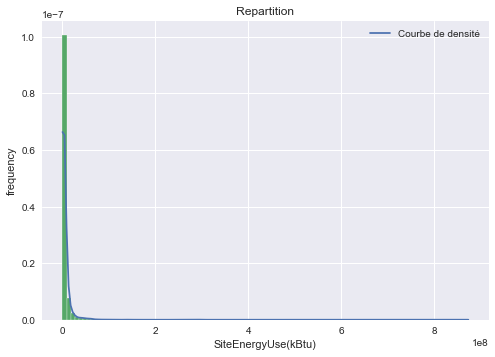

In [33]:
plot_histo(data[target_energy], title='Repartition', xlabel='SiteEnergyUse(kBtu)', drop_outliers=0, bins=100, plot_density=True, savefig=False)

In [34]:
data = data[data['PropertyGFABuilding(s)'] < 4e6] #Big outlier

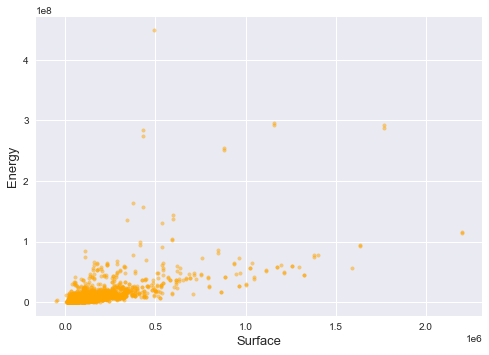

In [35]:
fig, ax = plt.subplots()
ax.scatter(x = data['PropertyGFABuilding(s)'], y = data[target_energy], marker='.', alpha=0.5, color='orange')
plt.ylabel('Energy', fontsize=13)
plt.xlabel('Surface', fontsize=13)
plt.show()

In [36]:
data = data[data[target_energy] < 2e8]

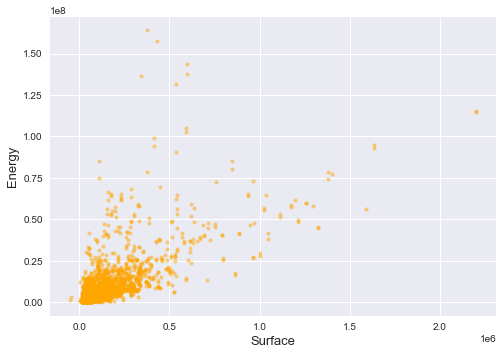

In [37]:
fig, ax = plt.subplots()
ax.scatter(x = data['PropertyGFABuilding(s)'], y = data[target_energy], marker='.', alpha=0.5, color='orange')
plt.ylabel('Energy', fontsize=13)
plt.xlabel('Surface', fontsize=13)
plt.show()

### Rescaling

Avec SciPy


 mu = 4685267.50 and sigma = 9860911.35



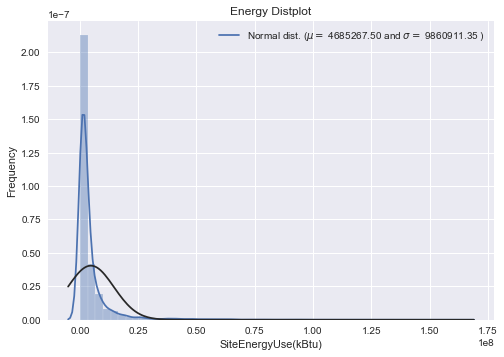

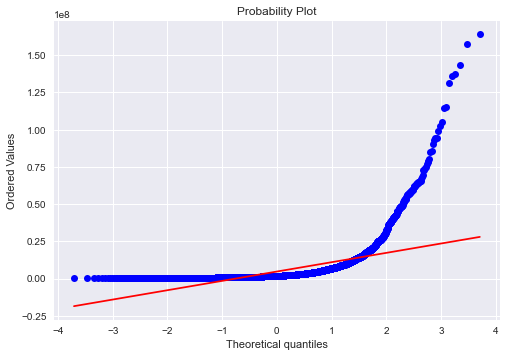

In [38]:
sns.distplot(data[target_energy].dropna() , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data[target_energy].dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Energy Distplot')
plt.savefig('plots_storage/distplot_energy.png', dpi=720,  bbox_inches='tight')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data[target_energy].dropna(), plot=plt)
plt.savefig('plots_storage/QQ_plot_energy.png', dpi=720,  bbox_inches='tight')
plt.show()


In [39]:
data[target_energy].skew()

6.55871878571109

Données très asymétriques

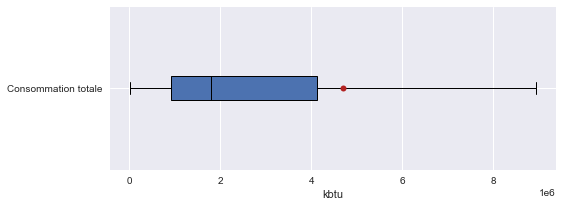

In [40]:
plot_boxplot(data[target_energy].dropna(), ["Consommation totale"], title=None, xlabel="kbtu")

In [41]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data[target_energy+'Norm'] = np.log1p(data[target_energy])


 mu = 14.56 and sigma = 1.14



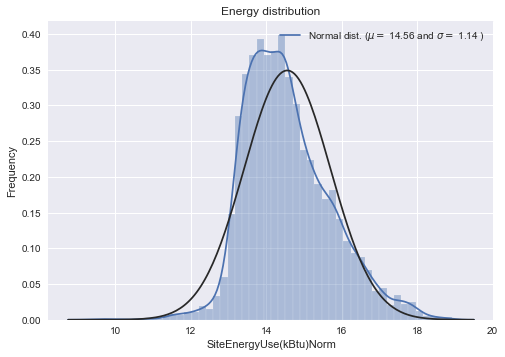

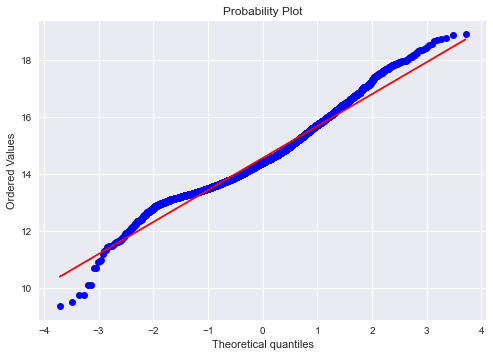

In [42]:
#Check the new distribution 
sns.distplot(data[target_energy+'Norm'].dropna(), fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data[target_energy+'Norm'].dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Energy distribution')
plt.savefig('plots_storage/distplot_energy_log.png', dpi=720,  bbox_inches='tight')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data[target_energy+'Norm'], plot=plt)
plt.savefig('plots_storage/QQ_plot_energy_log.png', dpi=720,  bbox_inches='tight')
plt.show()

Avec Sklearn:

In [43]:
scaler = StandardScaler()
scaler.fit(data[target_energy+'Norm'].values.reshape(-1, 1))

StandardScaler()

In [44]:
pd.DataFrame(scaler.transform(data[target_energy+'Norm'].values.reshape(-1, 1)), columns=['norm_data'])

,norm_data
0,1.048863
1,1.205931
2,3.104138
3,2.271276
4,1.708003
...,...
6666,-0.793864
6667,-0.696030
6668,0.881490
6669,-0.939475


In [45]:
data_energy_norm = pd.DataFrame(scaler.transform(data[target_energy+'Norm'].values.reshape(-1, 1)), columns=['norm_data'])


 mu = -0.00 and sigma = 1.00



Text(0.5, 1.0, 'Distric')

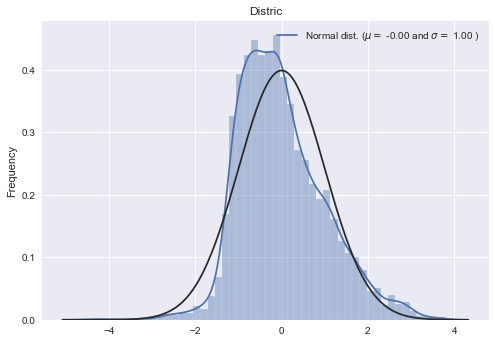

In [46]:
sns.distplot(data_energy_norm.dropna() , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_energy_norm.dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Distric')

#Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(data_energy_norm.dropna(), plot=plt)
# plt.show()

le log fait la même chose que Scaler

<a id='3_univ_emissions'></a>

### Emissions 🌋

In [47]:
data[target_emissions].describe()

count    6667.000000
mean      101.269138
std       269.799981
min        -0.800000
25%         9.460000
50%        33.220000
75%        91.140000
max      6330.910000
Name: TotalGHGEmissions, dtype: float64

In [48]:
data[target_emissions].isnull().value_counts()

False    6667
True        4
Name: TotalGHGEmissions, dtype: int64

No handles with labels found to put in legend.


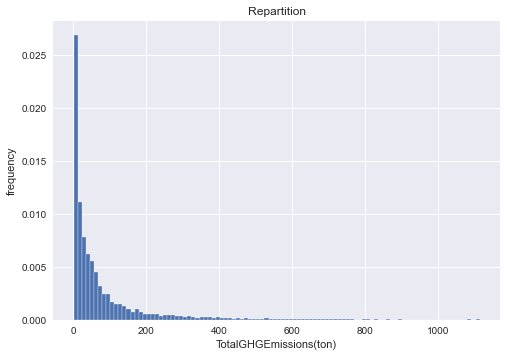

In [49]:
plot_histo(data[target_emissions], title='Repartition', xlabel='TotalGHGEmissions(ton)', drop_outliers=0.01, bins=100, plot_density=False, savefig='target_emissions_repartition')

In [50]:
data = data[data[target_emissions] > 0]

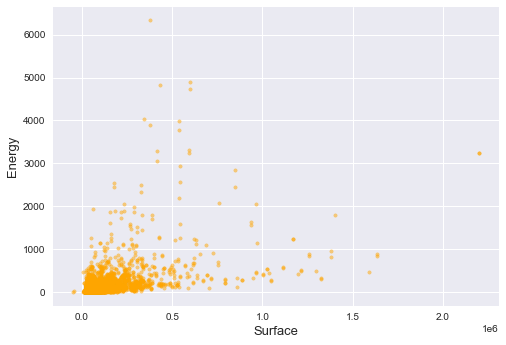

In [51]:
fig, ax = plt.subplots()
ax.scatter(x = data['PropertyGFABuilding(s)'], y = data[target_emissions], marker='.', alpha=0.5, color='orange')
plt.ylabel('Energy', fontsize=13)
plt.xlabel('Surface', fontsize=13)
plt.show()

Des surfaces négatives?

In [52]:
data = data[data['PropertyGFABuilding(s)']>0]

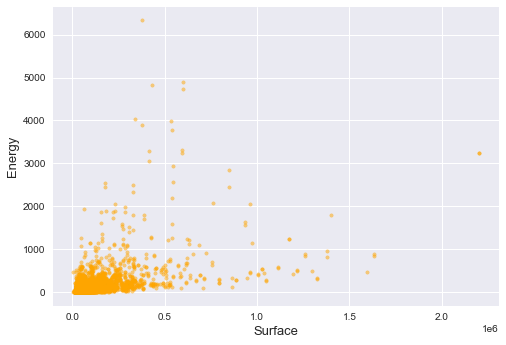

In [53]:
fig, ax = plt.subplots()
ax.scatter(x = data['PropertyGFABuilding(s)'], y = data[target_emissions], marker='.', alpha=0.5, color='orange')
plt.ylabel('Energy', fontsize=13)
plt.xlabel('Surface', fontsize=13)
plt.show()

In [54]:
data[target_emissions].skew()

9.821101084204084


 mu = 101.34 and sigma = 269.87



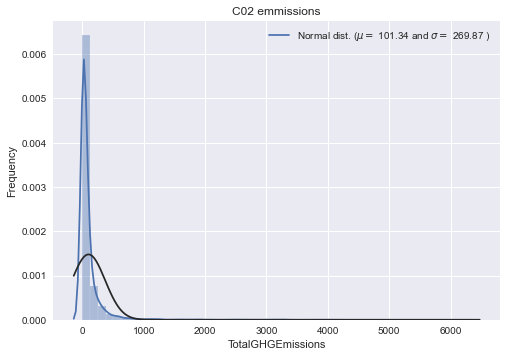

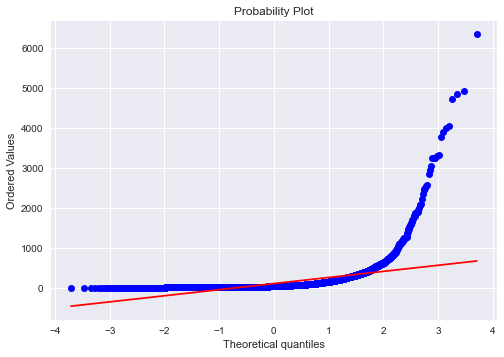

In [55]:
sns.distplot(data[target_emissions].dropna() , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data[target_emissions].dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('C02 emmissions')
plt.savefig('plots_storage/distplot_emissions.png', dpi=720,  bbox_inches='tight')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data[target_emissions].dropna(), plot=plt)
plt.savefig('plots_storage/QQ_emissions.png', dpi=720,  bbox_inches='tight')
plt.show()

Données très asymétriques

In [56]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data[target_emissions+'Norm'] = np.log1p(data[target_emissions])


 mu = 3.55 and sigma = 1.41



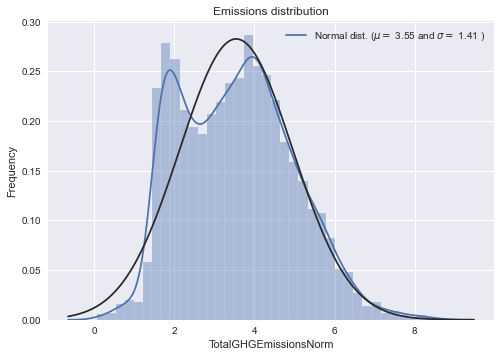

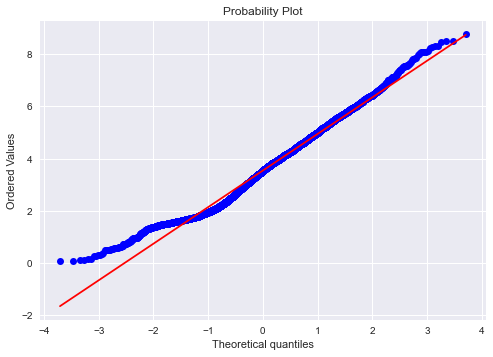

In [57]:
#Check the new distribution 
sns.distplot(data[target_emissions+'Norm'].dropna(), fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data[target_emissions+'Norm'].dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Emissions distribution')
plt.savefig('plots_storage/distplot_emissions_log.png', dpi=720,  bbox_inches='tight')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data[target_emissions+'Norm'], plot=plt)
plt.savefig('plots_storage/QQ_emissions_log.png', dpi=720,  bbox_inches='tight')
plt.show()

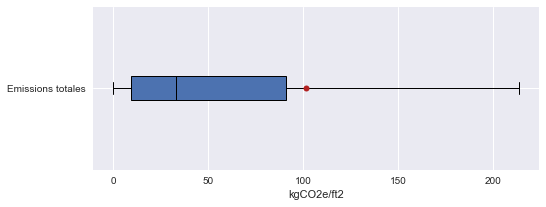

In [58]:
plot_boxplot(data[target_emissions].dropna(), ["Emissions totales"], title=None, xlabel="kgCO2e/ft2")

Avec Sklearn:

In [59]:
scaler = StandardScaler()
scaler.fit(data[target_emissions+'Norm'].values.reshape(-1, 1))

StandardScaler()

In [60]:
pd.DataFrame(scaler.transform(data[target_emissions+'Norm'].values.reshape(-1, 1)), columns=['norm_data'])

,norm_data
0,1.401638
1,1.440406
2,2.896033
3,2.851669
4,1.903916
...,...
6657,-0.324082
6658,-0.031130
6659,1.324295
6660,-0.287260


In [61]:
data_emissions_norm = pd.DataFrame(scaler.transform(data[target_emissions+'Norm'].values.reshape(-1, 1)), columns=['norm_data'])


 mu = -0.00 and sigma = 1.00



Text(0.5, 1.0, 'Energy consumption distribution')

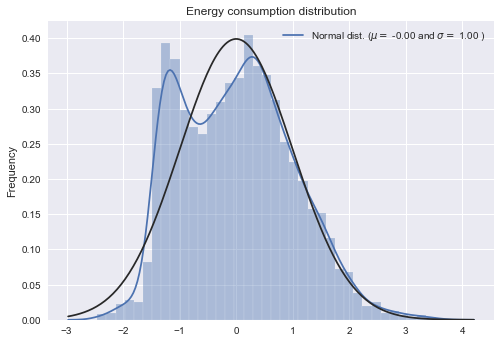

In [62]:
sns.distplot(data_emissions_norm.dropna() , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_emissions_norm.dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Energy consumption distribution')

#Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(data_energy_norm.dropna(), plot=plt)
# plt.show()

PAS MIEUX

## Données Catégoriques 🗂️

### Tri 

In [63]:
cols_dummies = []

In [64]:
# Noms colonnes catégoriques
cols_categ = data.dtypes[data.dtypes == object].index

In [65]:
cardinality_categ = pd.Series([len(data[col_categ].unique()) for col_categ in cols_categ], index=cols_categ)

In [66]:
cardinality_categ.sort_values(ascending=True)

State                               1
City                                2
ComplianceStatus                    3
DefaultData                         4
Outlier                             5
BuildingType                        8
Comments                            8
Neighborhood                       19
PrimaryPropertyType                32
ThirdLargestPropertyUseType        46
SecondLargestPropertyUseType       51
LargestPropertyUseType             58
ZipCode                            84
YearsENERGYSTARCertified          116
ListOfAllPropertyUseTypes         487
TaxParcelIdentificationNumber    3712
Longitude                        5836
Latitude                         6078
Address                          6332
PropertyName                     6479
dtype: int64

- State n'est pas interessant (cardinalité 1)

In [67]:
data.City.value_counts()

Seattle    3340
SEATTLE    3322
Name: City, dtype: int64

- City n'est pas interessant (cardinalité 1)

In [68]:
data.Outlier.value_counts()

High Outlier    46
Low Outlier     36
Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [69]:
data.replace({"Low outlier" : "Low Outlier",
              "High outlier" : "High Outlier"},
             inplace=True)

In [70]:
data.Outlier = data.Outlier.fillna(False)

- Outlier : à voir dans la matrice de corrélation

In [71]:
cols_dummies.append('Outlier')

In [72]:
data.ComplianceStatus.unique()

array(['Compliant', 'Error - Correct Default Data', 'Non-Compliant'],
      dtype=object)

In [73]:
data.replace({"Non-Compliant" : "Not Compliant",
              "Missing Data": "Unknown",
              "Error - Correct Default Data": "Unknown"},
             inplace=True)

- ComplianceStatus : Probablement interessant, à voir dans la matrice de corrélation

In [74]:
cols_dummies.append('ComplianceStatus')

In [75]:
data.DefaultData.unique()

array(['No', 'Yes', False, True], dtype=object)

In [76]:
data.DefaultData.replace({"No": False, "Yes": True}, inplace=True)

- DefaultData : A garder mais pas pour les corrélation

In [77]:
data.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

BuildingType à garder en dummies pour corrélations

In [78]:
cols_dummies.append('BuildingType')

In [79]:
data.Comments.isnull().value_counts()                   

True     6655
False       7
Name: Comments, dtype: int64

- Comments pas assez renseigné

In [80]:
data.Neighborhood.unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE', 'Ballard',
       'North', 'Delridge', 'Northwest', 'Central',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [81]:
data.Neighborhood.replace({"DELRIDGE NEIGHBORHOODS":"DELRIDGE", 
                           "MAGNOLIA / QUEEN ANNE":"MAGNOLIA QUEEN ANNE"}, inplace=True)

In [82]:
def mixCase(string):
    string = string.strip('\n')
    string = string.replace('-', ' ')
    string = string.replace('/',  ' ')
    capitalized_list = [word.strip(' ').capitalize() for word in string.split(' ')]
    mixed_case_string = ''
    for word in capitalized_list:
        mixed_case_string += word
    return mixed_case_string

In [83]:
data.Neighborhood = data.Neighborhood.apply(mixCase)

- On garde cette colonne

In [84]:
cols_dummies.append('Neighborhood')

In [85]:
data.PrimaryPropertyType.unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Low-Rise Multifamily', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store', 'Office'], dtype=object)

In [86]:
data.PrimaryPropertyType = data.PrimaryPropertyType.apply(mixCase)

In [87]:
cols_dummies.append('PrimaryPropertyType')

In [88]:
data.CouncilDistrictCode = data.CouncilDistrictCode.astype(str)

In [89]:
cols_dummies.append('CouncilDistrictCode')

In [90]:
cols_dummies

['Outlier',
 'ComplianceStatus',
 'BuildingType',
 'Neighborhood',
 'PrimaryPropertyType',
 'CouncilDistrictCode']

## Valeurs manquantes

In [91]:
missing = pd.Series([data[col].isna().sum() for col in data.columns], index=data.columns)

In [92]:
missing[missing > 0].sort_values(ascending=True)

SiteEnergyUseWN(kBtu)                                               1
SiteEUIWN(kBtu/sf)                                                  1
TaxParcelIdentificationNumber                                       2
NumberofFloors                                                      8
ZipCode                                                            16
ListOfAllPropertyUseTypes                                         124
LargestPropertyUseType                                            144
LargestPropertyUseTypeGFA                                         144
ENERGYSTARScore                                                  1583
Zip Codes                                                        3340
OtherFuelUse(kBtu)                                               3340
Seattle Police Department Micro Community Policing Plan Areas    3342
SPD Beats                                                        3342
SecondLargestPropertyUseType                                     3438
SecondLargestPropert

SiteEnergyUseWN(kBtu)

In [93]:
data.shape

(6662, 54)

In [94]:
cols_util_with_na = ['SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)',
                    'NumberofFloors', 'LargestPropertyUseTypeGFA', 
                    'LargestPropertyUseType']
cols_inutil_with_na = ['TaxParcelIdentificationNumber',
                       'ZipCode',
                       'ListOfAllPropertyUseTypes',                                         
                       'Zip Codes',
                       'OtherFuelUse(kBtu)',
                       'Seattle Police Department Micro Community Policing Plan Areas',
                       'SPD Beats',
                       'SecondLargestPropertyUseTypeGFA',
                       'SecondLargestPropertyUseType',
                       'ThirdLargestPropertyUseTypeGFA',
                       'ThirdLargestPropertyUseType',
                       'YearsENERGYSTARCertified',
                       '2010 Census Tracts',
                       'City Council Districts',
                       'Comments',]

In [95]:
data.drop(columns=cols_inutil_with_na, inplace=True)

In [96]:
data.dropna(subset=cols_util_with_na, inplace=True)

In [97]:
data.shape

(6509, 39)

### Création des dummies 🤡

In [98]:
encoded_columns = pd.get_dummies(data[cols_dummies])
data = pd.concat([data, encoded_columns], axis=1)

In [99]:
data.to_csv('data/data_full_post_analisis.csv')

<a id='2_correlations'></a>

## Matrice de corrélation

In [100]:
# Réorganisation des index pour meilleure lisibilité
new_col_index = list(data.columns)
new_col_index.remove(target_energy)
new_col_index.remove(target_emissions)
new_col_index.insert(0, target_energy)
new_col_index.insert(0, target_emissions)
data = data.reindex(columns=new_col_index)

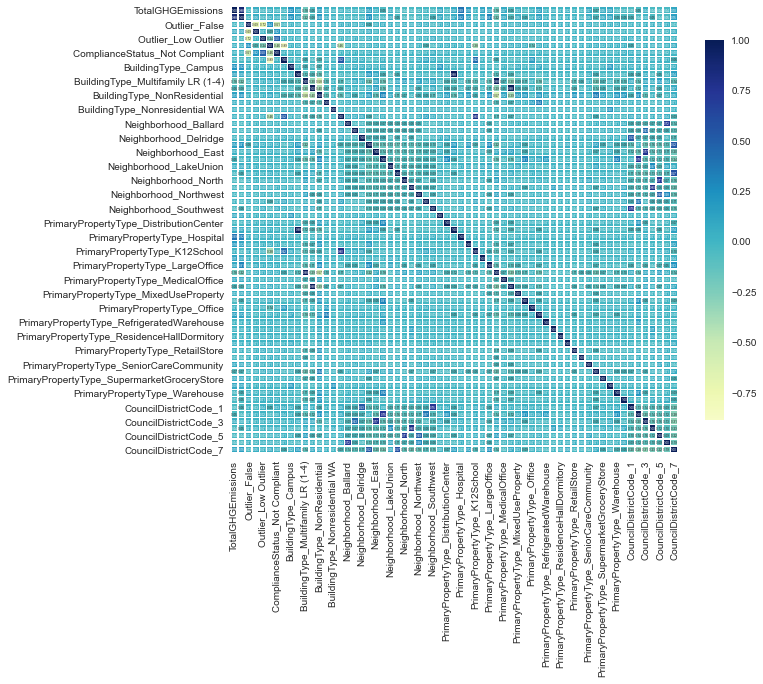

In [101]:
matrice_correlation = correlation_heatmap(data[[target_emissions, target_energy] + list(encoded_columns.columns)], savefig='heat_map_categs')

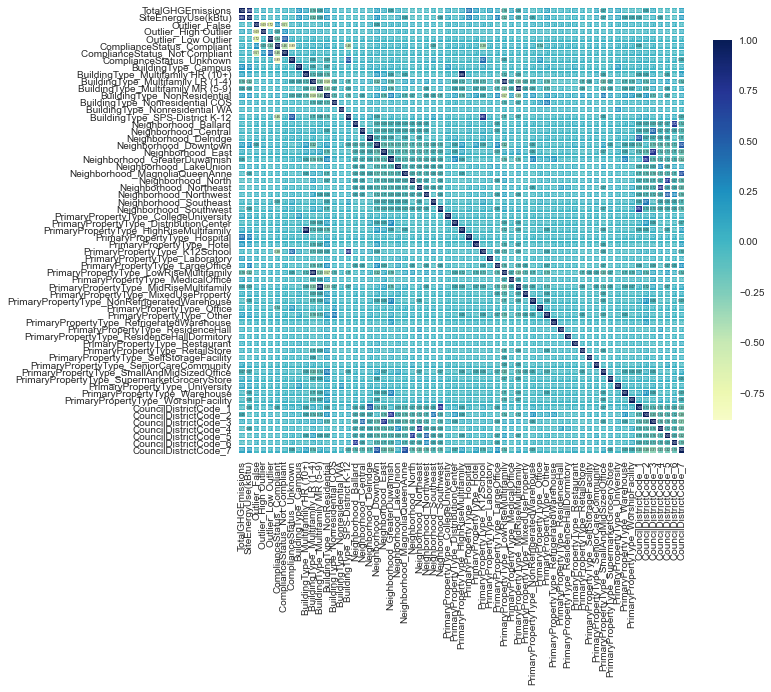

In [102]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrice_correlation, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70},
            annot_kws={'fontsize':3}, 
            xticklabels=[target_emissions, target_energy] + list(encoded_columns.columns),
            yticklabels=[target_emissions, target_energy] + list(encoded_columns.columns))
plt.savefig('plots_storage/heat_map_categs.png', bbox_inches='tight', dpi=720)

In [103]:
matrice_correlation.shape

(63, 63)

<a id='2_features_correlees'></a>

## Analyses des features corrélées 🎶

### PropertyGFABuilding(s) (Surface des batiments)

On voit que les surfaces DFA sont fortement corrélées avec les cibles. Je choisi la donnée de surface des batiments car elle a un meilleur score de corrélation et que les autres sont corrélées entre elles

In [104]:
feature_surface = 'PropertyGFABuilding(s)'

In [105]:
data[feature_surface].describe()

count    6.509000e+03
mean     8.052387e+04
std      1.258771e+05
min      3.636000e+03
25%      2.725000e+04
50%      4.207800e+04
75%      8.070100e+04
max      2.200000e+06
Name: PropertyGFABuilding(s), dtype: float64

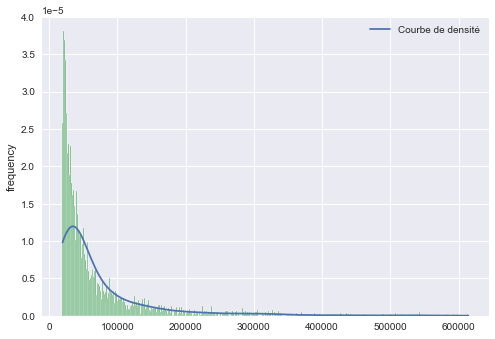

In [106]:
plot_histo(data[feature_surface], title=None, xlabel=None, drop_outliers=0.01, bins=500, plot_density=True, savefig=False)

In [107]:
data[feature_surface].skew()

6.4038755737102155

In [108]:
data_biv_surf = data[data[feature_surface] < 8e6][[feature_surface, target_energy, target_emissions]]

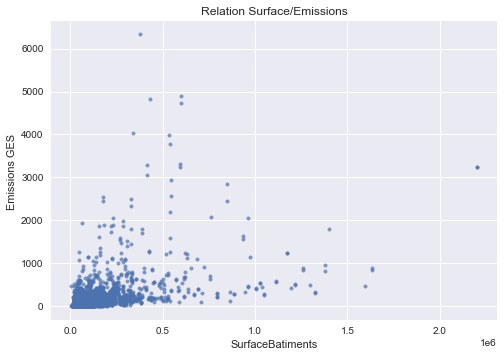

In [109]:
plt.scatter(data_biv_surf[feature_surface], data_biv_surf[target_emissions], alpha=0.7, marker='.')
plt.xlabel("SurfaceBatiments")
plt.ylabel("Emissions GES ")
plt.title("Relation Surface/Emissions")
plt.show()

In [110]:
data.shape

(6509, 100)